 # ML for Environmental Engineering 
 By: Suheyla Tozan and Steven Gutterman

## Module Import

In [2]:
!pip install openpyxl
!pip install tensorflow
!pip install hyperopt
!pip install pandas
!pip install matplotlib
!pip install xarray
!pip install seaborn
!pip install scikit-learn
!pip install utils
!pip install keras
!pip install --upgrade tensorflow

In [3]:
!pip install xgboost==1.7.6


In [4]:
# Import Modules
import os
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb
print("xgboost version = ",xgb.__version__)

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import *

xgboost version =  2.0.2


## Data Processing

/var/folders/93/5t7_3xxn2dvdtnjj99wxz2wc0000gn/T/ipykernel_37512/1828264225.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:, 'wind speed'].fillna(df_new['wind speed'].mean(), inplace=True)
/var/folders/93/5t7_3xxn2dvdtnjj99wxz2wc0000gn/T/ipykernel_37512/1828264225.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:, 'wind direction'].fillna(df_new['wind direction'].mean(), inplace=True)
/var/folders/93/5t7_3xxn2dvdtnjj99wxz2wc0000gn/T/ipykernel_37512/1828264225.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

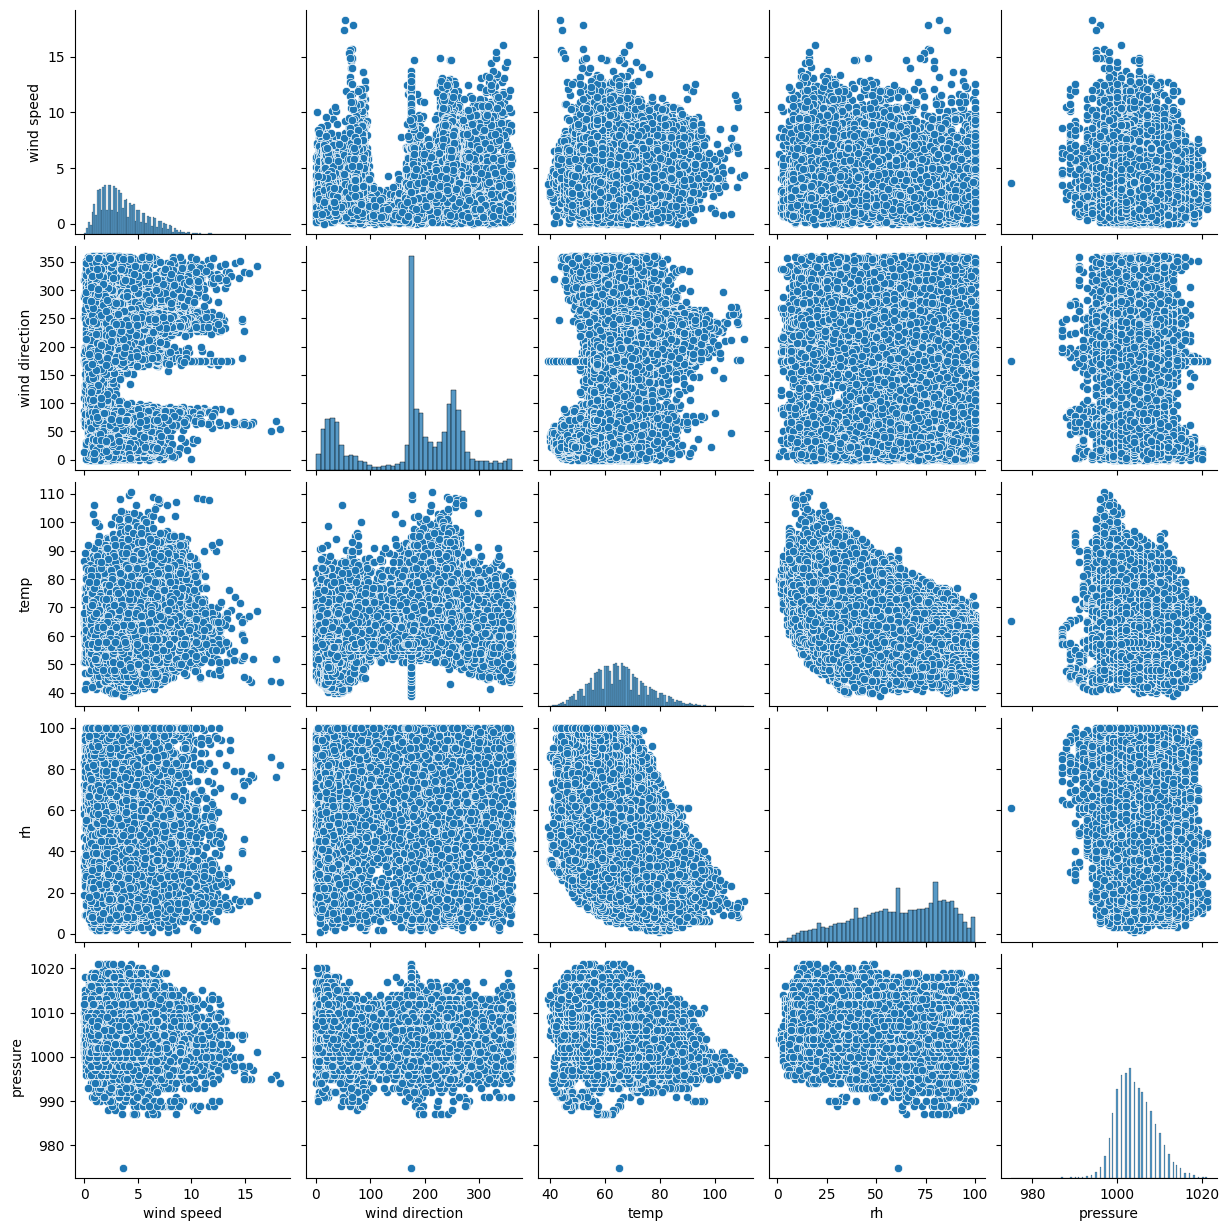

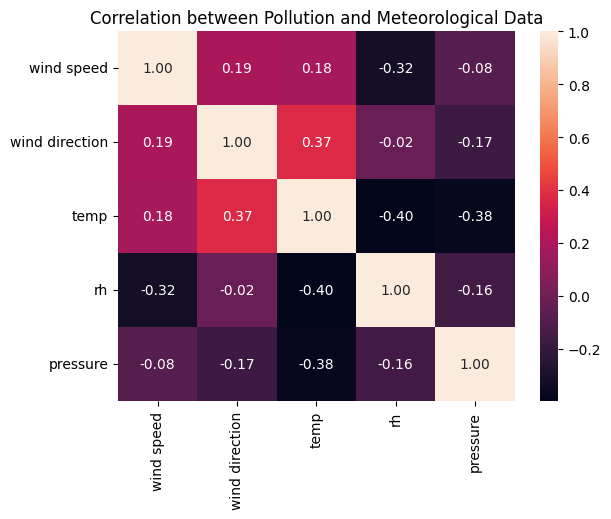

In [5]:
# 1. Data Processing: Prepare Data for Training & Testing

df = pd.read_excel("Data/metdata_2018-2023_ELABHWC.xlsx") #meterological data
df2 = pd.read_excel("Data/criteriagasdata_2018-2023_ELABHWC.xlsx") #air quality data


merged_df = pd.merge(df, df2, on=['date_gmt', 'time_gmt'], how='inner')
desired_columns = ['date_gmt', 'time_gmt', 'wind speed', 'wind direction', 'temp', 'rh', 'pressure', 'CO', 'NO2', 'SO2','O3','PM10']
final_df = merged_df[desired_columns]
co_original = final_df['CO']
no2_original = final_df['NO2']
so2_original = final_df['SO2']
o3_original = final_df['O3']
#Get rid of all predictand data that is 'NaN'
df_new = final_df.dropna(subset=['CO', 'NO2', 'SO2','O3'])

df_new.loc[:, 'wind speed'].fillna(df_new['wind speed'].mean(), inplace=True)
df_new.loc[:, 'wind direction'].fillna(df_new['wind direction'].mean(), inplace=True)
df_new.loc[:, 'temp'].fillna(df_new['temp'].mean(), inplace=True)
df_new.loc[:, 'rh'].fillna(df_new['rh'].mean(), inplace=True)
df_new.loc[:, 'pressure'].fillna(df_new['pressure'].mean(), inplace=True)

X_features = df_new[['wind speed', 'wind direction', 'temp', 'rh', 'pressure','date_gmt']]
y_co = df_new['CO']
y_no2 = df_new['NO2']
y_so2 = df_new['SO2']
y_o3 = df_new['O3']

#Pairplot
df_cor = df_new.drop(['date_gmt', 'time_gmt'], axis=1)
features = ['wind speed', 'wind direction', 'temp','rh','pressure']
subset_corr = df_cor[features]
sns.pairplot(subset_corr)
plt.savefig("pairplot.png")
plt.show()

#Heatmap
df_cor = df_new.drop(['date_gmt', 'time_gmt'], axis=1)
features = ['wind speed', 'wind direction', 'temp','rh','pressure']
subset_corr = df_cor[features]
correlation_matrix = subset_corr.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation between Pollution and Meteorological Data")
plt.savefig("heatmap.png")
plt.show()


#Determine Train and Test Data

#CO
X_train_co,X_test_co,y_train_co,y_test_co = train_test_split(X_features, y_co, test_size = 0.30, random_state = 512)
X_train_co = X_train_co[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_co = X_test_co['date_gmt']
X_test_co = X_test_co [['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]

#NO2
X_train_no2,X_test_no2,y_train_no2,y_test_no2 = train_test_split(X_features, y_no2, test_size = 0.30, random_state = 512)
X_train_no2 = X_train_no2[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_no2 = X_test_no2['date_gmt']
X_test_no2 = X_test_no2 [['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]

#SO2
X_train_so2,X_test_so2,y_train_so2,y_test_so2 = train_test_split(X_features, y_so2, test_size = 0.30, random_state = 512)
X_train_so2 = X_train_so2[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_so2 = X_test_so2['date_gmt']
X_test_so2 = X_test_so2[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]

#O3
X_train_o3,X_test_o3,y_train_o3,y_test_o3 = train_test_split(X_features, y_o3, test_size = 0.30, random_state = 512)
X_train_o3 = X_train_o3[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_o3 = X_test_o3['date_gmt']
X_test_o3 = X_test_o3[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]


# Standardization
mean_co, std_co = X_train_co.mean(), X_train_co.std()
mean_no2, std_no2 = X_train_no2.mean(), X_train_no2.std()
mean_so2, std_so2 = X_train_so2.mean(), X_train_so2.std()
mean_o3, std_o3 = X_train_o3.mean(), X_train_o3.std()

#CO
X_train_co = (X_train_co - mean_co)/std_co
X_test_co = (X_test_co - mean_co)/std_co
#NO2
X_train_no2 = (X_train_no2 - mean_no2)/std_no2
X_test_no2 = (X_test_no2 - mean_no2)/std_no2
#SO2
X_train_so2 = (X_train_so2 - mean_so2)/std_so2
X_test_so2 = (X_test_so2 - mean_so2)/std_so2
#O3
X_train_o3 = (X_train_o3 - mean_o3)/std_o3
X_test_o3 = (X_test_o3 - mean_o3)/std_o3

X_train_fi_co = pd.DataFrame(X_train_co, columns=features)
X_train_co = X_train_co.to_numpy()
y_train_co = y_train_co.to_numpy()
X_test_co = X_test_co.to_numpy()

X_train_fi_no2 = pd.DataFrame(X_train_no2, columns=features)
X_train_no2 = X_train_no2.to_numpy()
y_train_no2 = y_train_no2.to_numpy()
X_test_no2 = X_test_no2.to_numpy()

X_train_fi_so2 = pd.DataFrame(X_train_so2, columns=features)
X_train_so2 = X_train_so2.to_numpy()
y_train_so2 = y_train_so2.to_numpy()
X_test_so2 = X_test_so2.to_numpy()

X_train_fi_o3 = pd.DataFrame(X_train_o3, columns=features)
X_train_o3 = X_train_o3.to_numpy()
y_train_o3 = y_train_o3.to_numpy()
X_test_o3 = X_test_o3.to_numpy()

## Function for Model Evaluation

In [6]:
#Feature Importance
# The code below was retained from the following website with slight modifications: 
#https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html

def plot_feature_importance(importance,names, model, gas):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(6,6))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model}: {gas} Concentration Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

#Prediction Error Histogram
def prediction_error(outcome, input, model, gas):
    errors = outcome - input
    plt.hist(errors, bins=30, edgecolor='black', alpha=0.5)
    plt.title(f'{model}: {gas} Concentration Model Evlaution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')

## CO Model Building

In [7]:
#CO
# The following code has been taken from Professor Pierre Gentine's notes for EAEE 4000 Machine Learning for Environmental Engineering
# XGBoost Lecture

# hyperparameters option list
n_estimators_list = [int(x) for x in np.linspace(start=20, stop=100, num=9)]
max_depth_list = [5, 10, 15]
reg_alpha_list = [0.1, 0.2, 0.3]
reg_lambda_list = [0.7, 0.8, 0.9]
subsample_list = [0.7, 0.8, 0.9, 1]
eta_list = [0.05, 0.1, 0.001]
eval_metric_list = ['rmse','mae','mape','logloss']

# Initialize domain space for range of values 
space={'n_estimators': hp.choice('n_estimators', n_estimators_list),
       'max_depth': hp.choice("max_depth", max_depth_list),
       'gamma': hp.uniform ('gamma', 0, 2),
       'reg_alpha' : hp.choice('reg_alpha', reg_alpha_list),
       'reg_lambda' : hp.choice('reg_lambda', reg_lambda_list),
       'subsample' : hp.choice('subsample', subsample_list),
       'eta' : hp.choice('eta', eta_list),
       'eval_metric' : hp.choice('eval_metric', eval_metric_list),
       'tree_method' : 'hist',
       'seed': 5
    }

# define objective function
def objective(space):
    n_estimators = space['n_estimators']
    learning_rate = space['eta']
    gamma = space['gamma']
    max_depth = int(space['max_depth'])
    subsample = space['subsample']
    lamb = space['reg_lambda']
    alpha = space['reg_alpha']
    eval_metric = space['eval_metric']
    seed = space['seed']
    
    xgb_regressor = XGBRegressor(n_estimators = n_estimators,
                                 eta = learning_rate,
                                 gamma = gamma,
                                 max_depth = max_depth,
                                 subsample = subsample,
                                 reg_lambda = lamb,
                                 reg_alpha = alpha,
                                 tree_method = 'hist',
                                 eval_metric = eval_metric,
                                 seed = 5,
                                 verbosity = 1)

    
    xgb_regressor.fit(X_train_co, y_train_co)
    
    y_test_pred = xgb_regressor.predict(X_test_co)
    
    rmse = mean_squared_error(y_test_co, y_test_pred, squared=False)
    print("loss (rmse): "+str(rmse))
    print("n_estimators = "+str(n_estimators)+"; eta = "+str(learning_rate)+"; gamma = "+str(gamma)+"; max_depth = "+str(max_depth))
    print("subsample = "+str(subsample)+"; reg_lambda = "+str(lamb)+"; reg_alpha = "+str(alpha)+"; eval_metric = "+str(eval_metric))
    print('----------------------------------------------------------------------------------------')
    return {'loss': rmse, 'status': STATUS_OK }

# find the best hyperparameters of 10 trials
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams) # if hp.choice, the output is the position of the list
print("eta = ", eta_list[best_hyperparams['eta']]) # an example of find the exact value of the position


# build a regressor with the best hyperparameters
xgb_regressor1 = XGBRegressor(n_estimators = n_estimators_list[best_hyperparams['n_estimators']],
                              eta = eta_list[best_hyperparams['eta']],
                              gamma = best_hyperparams['gamma'],
                              max_depth = max_depth_list[best_hyperparams['max_depth']],
                              subsample = subsample_list[best_hyperparams['subsample']],
                              reg_lambda = reg_lambda_list[best_hyperparams['reg_lambda']],
                              reg_alpha = reg_alpha_list[best_hyperparams['reg_alpha']],
                              tree_method = 'hist',
                              eval_metric = eval_metric_list[best_hyperparams['eval_metric']],
                              seed = 5,
                              verbosity = 1)

xgb_regressor1.fit(X_train_co, y_train_co)

y_test_predco = xgb_regressor1.predict(X_test_co)
y_train_predco = xgb_regressor1.predict(X_train_co)


loss (rmse): 0.20294801019599779                                                                                                         
n_estimators = 50; eta = 0.05; gamma = 1.308222904433299; max_depth = 5                                                                  
subsample = 0.9; reg_lambda = 0.9; reg_alpha = 0.2; eval_metric = logloss                                                                
----------------------------------------------------------------------------------------                                                 
loss (rmse): 0.1993583255253713                                                                                                          
n_estimators = 90; eta = 0.05; gamma = 1.2305557940721936; max_depth = 15                                                                
subsample = 0.8; reg_lambda = 0.7; reg_alpha = 0.2; eval_metric = mae                                                                    
----------------------------------

In [8]:
# Best model based on hyperparameter tuning
# set up xgboost regressor
n_estimators  = 74     # specifies the number of decision trees to be boosted
learning_rate = 0.1    # learning_rate, range: [0,1]
gamma         = 0.7649081777981308      # Minimum loss reduction required to make a further partition on a leaf node of the tree,
                       # range: [0,∞]
max_depth     = 15     # Maximum depth of a tree, range: [0,∞]
subsample     = 1    # Subsample ratio of the training instances, range: (0,1]
lamb          = 0.7    # L2 regularization, range: [0,∞]
alpha         = 0.1    # L1 regularization, range: [0,∞]
tree_method   = 'hist' # The tree construction algorithm used in XGBoost
eval_metric   = 'mape' # Evaluation metrics for validation data; 
                       # Options: rmse, rmsle, mae, mape, logloss, etc
seed          = 5      # random number seed

xgb_regressor1 = XGBRegressor(n_estimators = n_estimators,
                              eta = learning_rate,
                              gamma = gamma,
                              max_depth = max_depth,
                              subsample = subsample,
                              reg_lambda = lamb,
                              reg_alpha = alpha,
                              tree_method = tree_method,
                              eval_metric = eval_metric,
                              seed = seed,
                              verbosity = 1)

xgb_regressor1.fit(X_train_co, y_train_co)

y_test_predco = xgb_regressor1.predict(X_test_co)
y_train_predco = xgb_regressor1.predict(X_train_co)

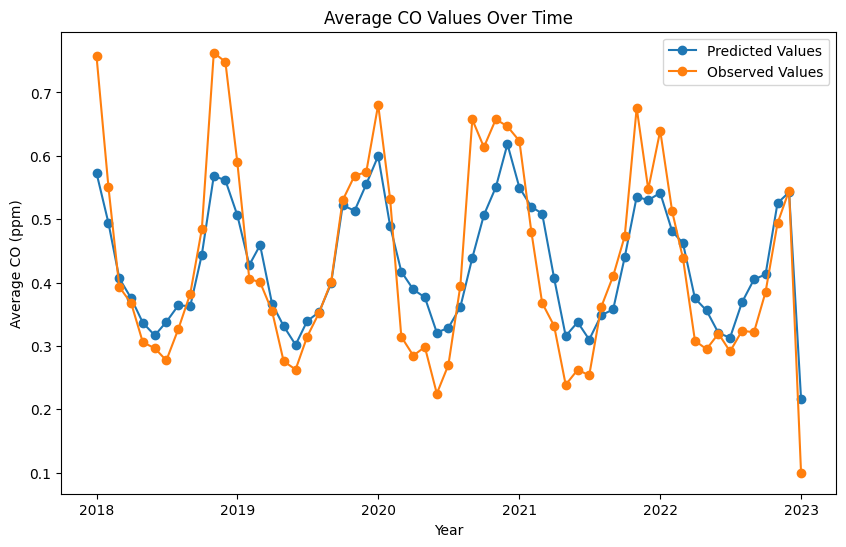

Test Mean Squared Error: 0.038594211015461066
Train Mean Squared Error: 0.035196912778988246
Test Mean Absolute Error: 0.13540089941021846
Train Mean Absolute Error: 0.12982592589457564
Test Root Mean Squared Error: 0.1964540939137209
Train Root Mean Squared Error: 0.1876084027408907
0.7396932940238823


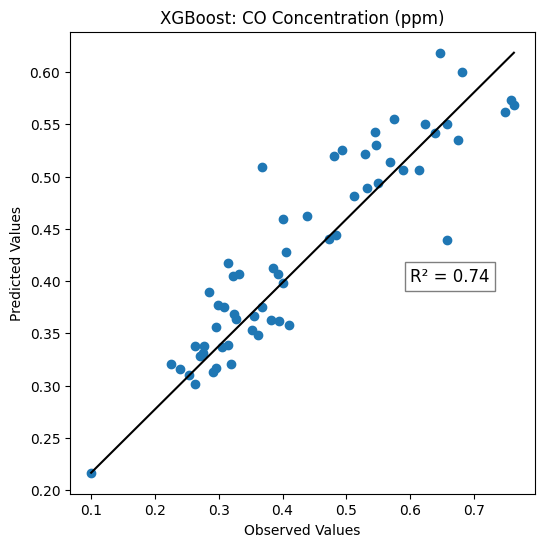

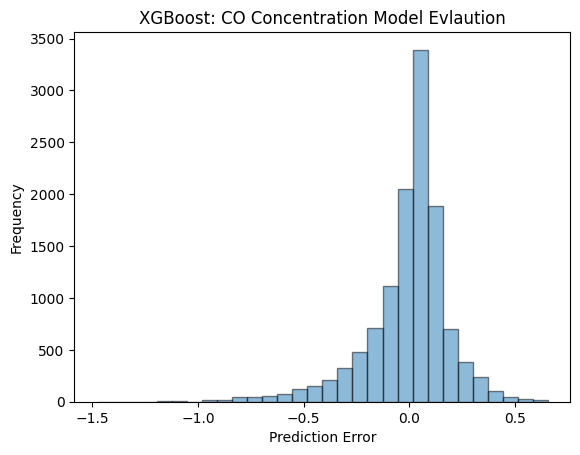

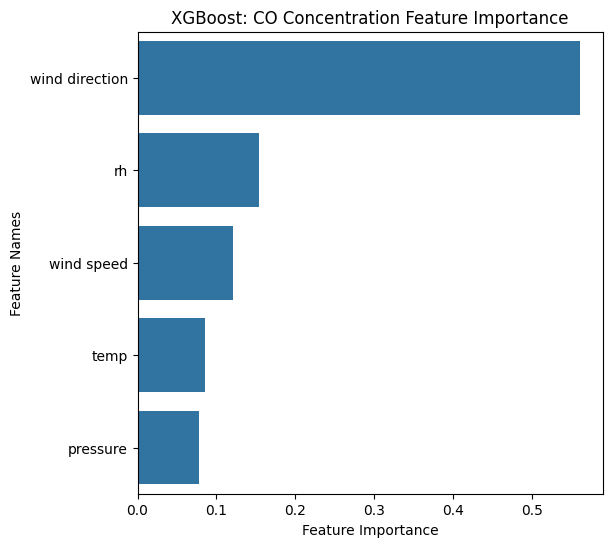

In [9]:
#CO
# Organize data into monthly averages and plot
y_test_predco = pd.Series(y_test_predco)
y_test_predco = y_test_predco.reset_index(drop=True)
time_test_co = time_test_co.reset_index(drop=True)
co_df  = pd.concat([y_test_predco, time_test_co], axis=1)
co_df.columns = ['CO', 'Date']
co_df['Date'] = pd.to_datetime(co_df['Date'])

# Extract year and month into new columns
co_df['Year'] = co_df['Date'].dt.year
co_df['Month'] = co_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
average_values = co_df.groupby(['Year', 'Month'])['CO'].mean()
average_values_df1 = average_values.reset_index()

#Repeat all above for observed data
y_test_co = pd.Series(y_test_co)
y_test_co = y_test_co.reset_index(drop=True)
co_test_df = pd.concat([y_test_co, time_test_co], axis=1)
co_test_df.columns = ['CO', 'Date']
co_test_df['Date'] = pd.to_datetime(co_test_df['Date'])

# Extract year and month into new columns
co_test_df['Year'] = co_test_df['Date'].dt.year
co_test_df['Month'] = co_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
average_values1 = co_test_df.groupby(['Year', 'Month'])['CO'].mean()
average_values_df2 = average_values1.reset_index()

#Change the series values to dataframes.
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(average_values_df1['Date'], average_values_df1['CO'], marker='o', label="Predicted Values")  
plt.plot(average_values_df2['Date'], average_values_df2['CO'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average CO Values Over Time')
plt.xlabel('Year')
plt.ylabel('Average CO (ppm)')
plt.legend()
plt.show()

# evaluate the predictions
mse1 = mean_squared_error(y_test_co, y_test_predco)
print("Test Mean Squared Error:", mse1)
mse2 = mean_squared_error(y_train_co, y_train_predco)
print("Train Mean Squared Error:", mse2)

mae1 = mean_absolute_error(y_test_co, y_test_predco)
print(f"Test Mean Absolute Error: {mae1}")
mae2 = mean_absolute_error(y_train_co, y_train_predco)
print(f"Train Mean Absolute Error: {mae2}")

rmse1 = mean_squared_error(y_test_co, y_test_predco, squared=False)
print(f"Test Root Mean Squared Error: {rmse1}")
rmse2 = mean_squared_error(y_train_co, y_train_predco, squared=False)
print(f"Train Root Mean Squared Error: {rmse2}")

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(average_values_df2['CO'], average_values_df1['CO'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(average_values_df2['CO'], average_values_df1['CO'])
plt.plot([average_values_df2['CO'].min(), average_values_df2['CO'].max()], [average_values_df1['CO'].min(), average_values_df1['CO'].max()], 'k-')  
plt.title(f'XGBoost: CO Concentration (ppm)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(0.6, 0.4 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()
   
#Error Prediction Histogram
prediction_error(y_test_predco, y_test_co, 'XGBoost','CO')

# #Feature Importance
plot_feature_importance(xgb_regressor1.feature_importances_, X_train_fi_co.columns, 'XGBoost','CO')

## NO2 Model Building

In [10]:
#NO2
# The following code has been taken from Professor Pierre Gentine's notes for EAEE 4000 Machine Learning for Environmental Engineering
# XGBoost Lecture

# hyperparameters option list
n_estimators_list = [int(x) for x in np.linspace(start=10, stop=80, num=5)]
max_depth_list = [5, 10, 15]
reg_alpha_list = [0.1, 0.2, 0.3]
reg_lambda_list = [0.7, 0.8]
subsample_list = [0.7, 0.8, 0.9]
eta_list = [0.01, 0.1, 0.001, 0.0001]
eval_metric_list = ['rmse','mae','mape','logloss']

# Initialize domain space for range of values 
space={'n_estimators': hp.choice('n_estimators', n_estimators_list),
       'max_depth': hp.choice("max_depth", max_depth_list),
       'gamma': hp.uniform ('gamma', 5, 10),
       'reg_alpha' : hp.choice('reg_alpha', reg_alpha_list),
       'reg_lambda' : hp.choice('reg_lambda', reg_lambda_list),
       'subsample' : hp.choice('subsample', subsample_list),
       'eta' : hp.choice('eta', eta_list),
       'eval_metric' : hp.choice('eval_metric', eval_metric_list),
       'tree_method' : 'hist',
       'seed': 5
    }

# define objective function
def objective(space):
    n_estimators = space['n_estimators']
    learning_rate = space['eta']
    gamma = space['gamma']
    max_depth = int(space['max_depth'])
    subsample = space['subsample']
    lamb = space['reg_lambda']
    alpha = space['reg_alpha']
    eval_metric = space['eval_metric']
    seed = space['seed']
    
    xgb_regressor = XGBRegressor(n_estimators = n_estimators,
                                 eta = learning_rate,
                                 gamma = gamma,
                                 max_depth = max_depth,
                                 subsample = subsample,
                                 reg_lambda = lamb,
                                 reg_alpha = alpha,
                                 tree_method = 'hist',
                                 eval_metric = eval_metric,
                                 seed = 5,
                                 verbosity = 1)

    
    xgb_regressor.fit(X_train_no2, y_train_no2)
    
    y_test_pred2 = xgb_regressor.predict(X_test_no2)
    
    rmse = mean_squared_error(y_test_no2, y_test_pred2, squared=False)
    print("loss (rmse): "+str(rmse))
    print("n_estimators = "+str(n_estimators)+"; eta = "+str(learning_rate)+"; gamma = "+str(gamma)+"; max_depth = "+str(max_depth))
    print("subsample = "+str(subsample)+"; reg_lambda = "+str(lamb)+"; reg_alpha = "+str(alpha)+"; eval_metric = "+str(eval_metric))
    print('----------------------------------------------------------------------------------------')
    return {'loss': rmse, 'status': STATUS_OK }

# find the best hyperparameters of 10 trials
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams) # if hp.choice, the output is the position of the list
print("eta = ", eta_list[best_hyperparams['eta']]) # an example of find the exact value of the position


# build a regressor with the best hyperparameters
xgb_regressor2 = XGBRegressor(n_estimators = n_estimators_list[best_hyperparams['n_estimators']],
                              eta = eta_list[best_hyperparams['eta']],
                              gamma = best_hyperparams['gamma'],
                              max_depth = max_depth_list[best_hyperparams['max_depth']],
                              subsample = subsample_list[best_hyperparams['subsample']],
                              reg_lambda = reg_lambda_list[best_hyperparams['reg_lambda']],
                              reg_alpha = reg_alpha_list[best_hyperparams['reg_alpha']],
                              tree_method = 'hist',
                              eval_metric = eval_metric_list[best_hyperparams['eval_metric']],
                              seed = 5,
                              verbosity = 1)

xgb_regressor2.fit(X_train_no2, y_train_no2)

y_test_predno2 = xgb_regressor2.predict(X_test_no2)
y_train_predno2 = xgb_regressor2.predict(X_train_no2)



loss (rmse): 7.652712562695364                                                                                                           
n_estimators = 80; eta = 0.1; gamma = 6.880192799219972; max_depth = 10                                                                  
subsample = 0.7; reg_lambda = 0.8; reg_alpha = 0.2; eval_metric = logloss                                                                
----------------------------------------------------------------------------------------                                                 
loss (rmse): 11.878708862055097                                                                                                          
n_estimators = 62; eta = 0.0001; gamma = 9.548113133768448; max_depth = 5                                                                
subsample = 0.9; reg_lambda = 0.8; reg_alpha = 0.1; eval_metric = rmse                                                                   
----------------------------------

In [11]:
# Best model based on hyperparameter tuning
# set up xgboost regressor
n_estimators  = 35     # specifies the number of decision trees to be boosted
learning_rate = 0.1    # learning_rate, range: [0,1]
gamma         = 6.498558601717666      # Minimum loss reduction required to make a further partition on a leaf node of the tree,
                       # range: [0,∞]
max_depth     = 10     # Maximum depth of a tree, range: [0,∞]
subsample     = 0.9    # Subsample ratio of the training instances, range: (0,1]
lamb          = 0.7    # L2 regularization, range: [0,∞]
alpha         = 0.3    # L1 regularization, range: [0,∞]
tree_method   = 'hist' # The tree construction algorithm used in XGBoost
eval_metric   = 'logloss' # Evaluation metrics for validation data; 
                       # Options: rmse, rmsle, mae, mape, logloss, etc
seed          = 5      # random number seed

xgb_regressor2 = XGBRegressor(n_estimators = n_estimators,
                              eta = learning_rate,
                              gamma = gamma,
                              max_depth = max_depth,
                              subsample = subsample,
                              reg_lambda = lamb,
                              reg_alpha = alpha,
                              tree_method = tree_method,
                              eval_metric = eval_metric,
                              seed = seed,
                              verbosity = 1)

xgb_regressor2.fit(X_train_no2, y_train_no2)

y_test_predno2 = xgb_regressor2.predict(X_test_no2)
y_train_predno2 = xgb_regressor2.predict(X_train_no2)

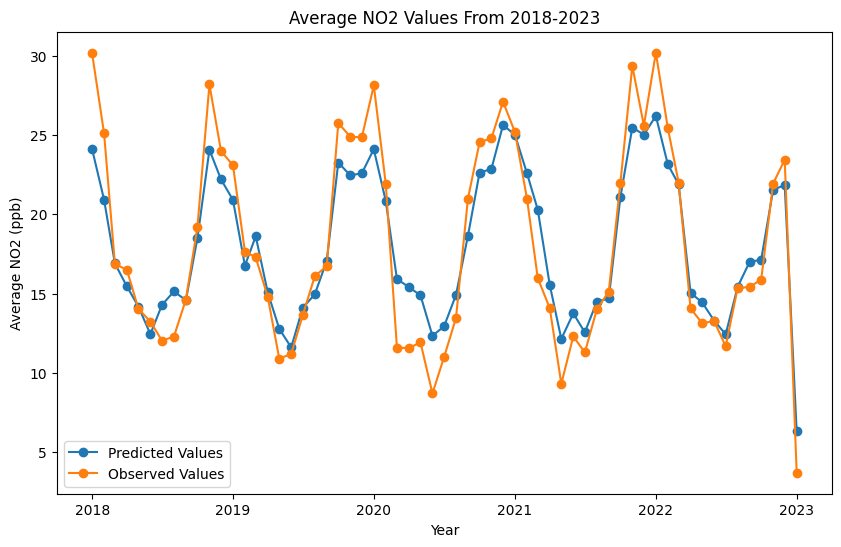

Test Mean Squared Error: 58.664649343802935
Train Mean Squared Error: 32.95818122703169
Test Mean Absolute Error: 5.543073412737873
Train Mean Absolute Error: 4.164561239005049
Test Root Mean Squared Error: 7.6592851718553305
Train Root Mean Squared Error: 5.740921635681129
0.8734944553960341


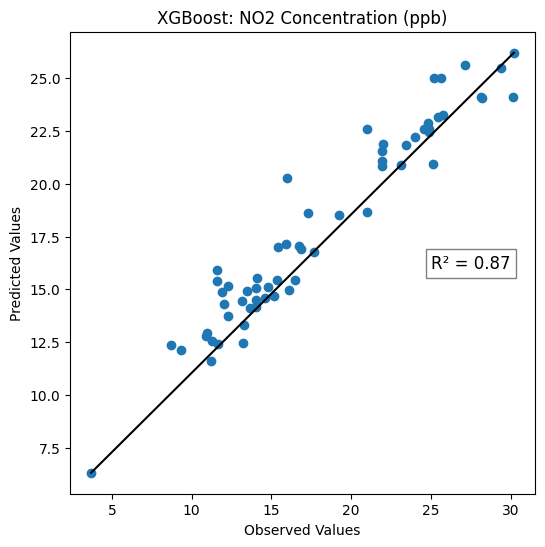

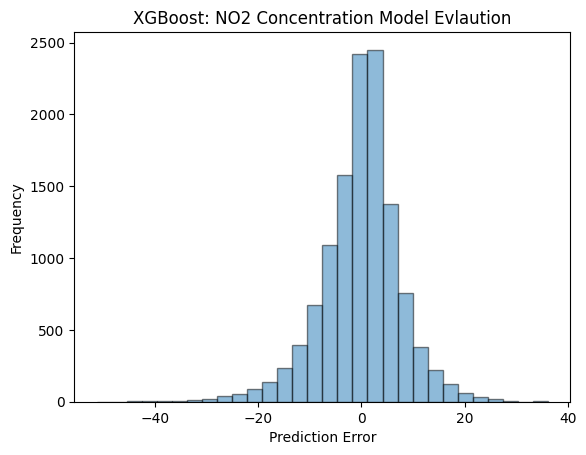

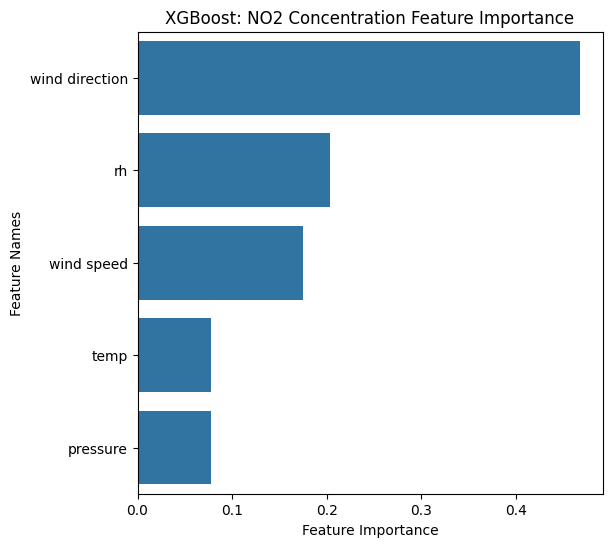

In [12]:
#NO2

# Organize data into monthly averages and plot
y_test_predno2 = pd.Series(y_test_predno2)
y_test_predno2 = y_test_predno2.reset_index(drop=True)
time_test_no2 = time_test_no2.reset_index(drop=True)
no2_df  = pd.concat([y_test_predno2, time_test_no2], axis=1)
no2_df.columns = ['NO2', 'Date']
no2_df['Date'] = pd.to_datetime(no2_df['Date'])

# Extract year and month into new columns
no2_df['Year'] = no2_df['Date'].dt.year
no2_df['Month'] = no2_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
no2_average_values = no2_df.groupby(['Year', 'Month'])['NO2'].mean()
no2_average_values_df1 = no2_average_values.reset_index()

#Repeat all above for observed data
y_test_no2 = pd.Series(y_test_no2)
y_test_no2 = y_test_no2.reset_index(drop=True)
time_test_no2 = time_test_no2.reset_index(drop=True)
no2_test_df = pd.concat([y_test_no2, time_test_no2], axis=1)
no2_test_df.columns = ['NO2', 'Date']
no2_test_df['Date'] = pd.to_datetime(no2_test_df['Date'])

# Extract year and month into new columns
no2_test_df['Year'] = no2_test_df['Date'].dt.year
no2_test_df['Month'] = no2_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
no2_average_values1 = no2_test_df.groupby(['Year', 'Month'])['NO2'].mean()
no2_average_values_df2 = no2_average_values1.reset_index()

#Change the series values to dataframes.
no2_average_values_df1['Date'] = pd.to_datetime(no2_average_values_df1['Year'].astype(str) + '-' + no2_average_values_df1['Month'].astype(str))
no2_average_values_df2['Date'] = pd.to_datetime(no2_average_values_df2['Year'].astype(str) + '-' + no2_average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(no2_average_values_df1['Date'], no2_average_values_df1['NO2'], marker='o', label="Predicted Values")  # Create a line plot
plt.plot(no2_average_values_df2['Date'], no2_average_values_df2['NO2'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average NO2 Values From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average NO2 (ppb)')
plt.legend()
plt.show()

# evaluate the predictions
mse3 = mean_squared_error(y_test_no2, y_test_predno2)
print("Test Mean Squared Error:", mse3)
mse4 = mean_squared_error(y_train_no2, y_train_predno2)
print("Train Mean Squared Error:", mse4)

mae3 = mean_absolute_error(y_test_no2, y_test_predno2)
print(f"Test Mean Absolute Error: {mae3}")
mae4 = mean_absolute_error(y_train_no2, y_train_predno2)
print(f"Train Mean Absolute Error: {mae4}")

rmse3 = mean_squared_error(y_test_no2, y_test_predno2, squared=False)
print(f"Test Root Mean Squared Error: {rmse3}")
rmse4 = mean_squared_error(y_train_no2, y_train_predno2, squared=False)
print(f"Train Root Mean Squared Error: {rmse4}")

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(no2_average_values_df2['NO2'], no2_average_values_df1['NO2'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(no2_average_values_df2['NO2'], no2_average_values_df1['NO2'])
plt.plot([no2_average_values_df2['NO2'].min(), no2_average_values_df2['NO2'].max()], [no2_average_values_df1['NO2'].min(), no2_average_values_df1['NO2'].max()], 'k-')  
plt.title(f'XGBoost: NO2 Concentration (ppb)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(25, 16 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

#Prediction Error Histogram
prediction_error(y_test_predno2, y_test_no2,'XGBoost', 'NO2')

#Feature Importance
plot_feature_importance(xgb_regressor2.feature_importances_, X_train_fi_no2.columns, 'XGBoost','NO2')




## SO2 Model Building

In [13]:
#SO2
# The following code has been taken from Professor Pierre Gentine's notes for EAEE 4000 Machine Learning for Environmental Engineering
# XGBoost Lecture

# hyperparameters option list
n_estimators_list = [int(x) for x in np.linspace(start=20, stop=100, num=9)]
max_depth_list = [5, 10, 15, 20]
reg_alpha_list = [0.1, 0.2, 0.3]
reg_lambda_list = [0.7, 0.8, 0.9]
subsample_list = [0.5, 0.6, 0.7, 0.8, 0.9]
eta_list = [0.05, 0.1, 0.001, 0.01]
eval_metric_list = ['rmse','mae','mape','logloss']

# Initialize domain space for range of values 
space={'n_estimators': hp.choice('n_estimators', n_estimators_list),
       'max_depth': hp.choice("max_depth", max_depth_list),
       'gamma': hp.uniform ('gamma', 0, 1),
       'reg_alpha' : hp.choice('reg_alpha', reg_alpha_list),
       'reg_lambda' : hp.choice('reg_lambda', reg_lambda_list),
       'subsample' : hp.choice('subsample', subsample_list),
       'eta' : hp.choice('eta', eta_list),
       'eval_metric' : hp.choice('eval_metric', eval_metric_list),
       'tree_method' : 'hist',
       'seed': 5
    }

# define objective function
def objective(space):
    n_estimators = space['n_estimators']
    learning_rate = space['eta']
    gamma = space['gamma']
    max_depth = int(space['max_depth'])
    subsample = space['subsample']
    lamb = space['reg_lambda']
    alpha = space['reg_alpha']
    eval_metric = space['eval_metric']
    seed = space['seed']
    
    xgb_regressor = XGBRegressor(n_estimators = n_estimators,
                                 eta = learning_rate,
                                 gamma = gamma,
                                 max_depth = max_depth,
                                 subsample = subsample,
                                 reg_lambda = lamb,
                                 reg_alpha = alpha,
                                 tree_method = 'hist',
                                 eval_metric = eval_metric,
                                 seed = 5,
                                 verbosity = 1)

    
    xgb_regressor.fit(X_train_so2, y_train_so2)
    
    y_test_pred3 = xgb_regressor.predict(X_test_so2)
    
    rmse = mean_squared_error(y_test_so2, y_test_pred3, squared=False)
    print("loss (rmse): "+str(rmse))
    print("n_estimators = "+str(n_estimators)+"; eta = "+str(learning_rate)+"; gamma = "+str(gamma)+"; max_depth = "+str(max_depth))
    print("subsample = "+str(subsample)+"; reg_lambda = "+str(lamb)+"; reg_alpha = "+str(alpha)+"; eval_metric = "+str(eval_metric))
    print('----------------------------------------------------------------------------------------')
    return {'loss': rmse, 'status': STATUS_OK }

# find the best hyperparameters of 100 trials
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 15,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams) # if hp.choice, the output is the position of the list
print("eta = ", eta_list[best_hyperparams['eta']]) # an example of find the exact value of the position


# build a regressor with the best hyperparameters
xgb_regressor3 = XGBRegressor(n_estimators = n_estimators_list[best_hyperparams['n_estimators']],
                              eta = eta_list[best_hyperparams['eta']],
                              gamma = best_hyperparams['gamma'],
                              max_depth = max_depth_list[best_hyperparams['max_depth']],
                              subsample = subsample_list[best_hyperparams['subsample']],
                              reg_lambda = reg_lambda_list[best_hyperparams['reg_lambda']],
                              reg_alpha = reg_alpha_list[best_hyperparams['reg_alpha']],
                              tree_method = 'hist',
                              eval_metric = eval_metric_list[best_hyperparams['eval_metric']],
                              seed = 5,
                              verbosity = 1)

xgb_regressor3.fit(X_train_so2, y_train_so2)

y_test_predso2 = xgb_regressor3.predict(X_test_so2)
y_train_predso2 = xgb_regressor3.predict(X_train_so2)



loss (rmse): 0.2732374801531886                                                                                                          
n_estimators = 40; eta = 0.01; gamma = 0.0853750090222859; max_depth = 15                                                                
subsample = 0.8; reg_lambda = 0.7; reg_alpha = 0.1; eval_metric = rmse                                                                   
----------------------------------------------------------------------------------------                                                 
loss (rmse): 0.2874937049399831                                                                                                          
n_estimators = 20; eta = 0.01; gamma = 0.709347423364443; max_depth = 20                                                                 
subsample = 0.7; reg_lambda = 0.8; reg_alpha = 0.2; eval_metric = logloss                                                                
----------------------------------

In [14]:
# Best model based on hyperparameter tuning
# set up xgboost regressor
n_estimators  = 83     # specifies the number of decision trees to be boosted
learning_rate = 0.1    # learning_rate, range: [0,1]
gamma         = 0.5469158848929764      # Minimum loss reduction required to make a further partition on a leaf node of the tree,
                       # range: [0,∞]
max_depth     = 15     # Maximum depth of a tree, range: [0,∞]
subsample     = 0.7    # Subsample ratio of the training instances, range: (0,1]
lamb          = 0.9    # L2 regularization, range: [0,∞]
alpha         = 0.3    # L1 regularization, range: [0,∞]
tree_method   = 'hist' # The tree construction algorithm used in XGBoost
eval_metric   = 'mape' # Evaluation metrics for validation data; 
                       # Options: rmse, rmsle, mae, mape, logloss, etc
seed          = 5      # random number seed

xgb_regressor3 = XGBRegressor(n_estimators = n_estimators,
                              eta = learning_rate,
                              gamma = gamma,
                              max_depth = max_depth,
                              subsample = subsample,
                              reg_lambda = lamb,
                              reg_alpha = alpha,
                              tree_method = tree_method,
                              eval_metric = eval_metric,
                              seed = seed,
                              verbosity = 1)

xgb_regressor3.fit(X_train_so2, y_train_so2)

y_test_predso2 = xgb_regressor3.predict(X_test_so2)
y_train_predso2 = xgb_regressor3.predict(X_train_so2)

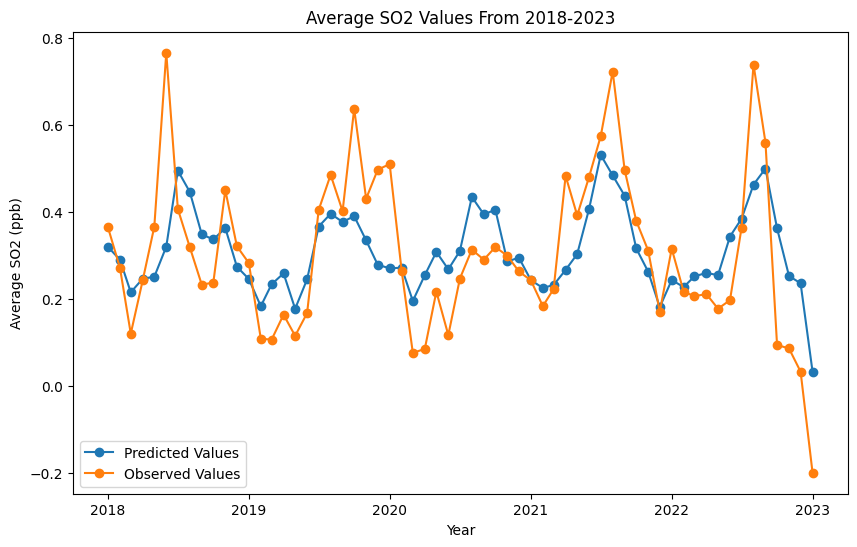

Test Mean Squared Error: 0.0633239122205445
Train Mean Squared Error: 0.05442860485897352
Test Mean Absolute Error: 0.17404995638276632
Train Mean Absolute Error: 0.16664001216941304
Test Root Mean Squared Error: 0.2516424292931232
Train Root Mean Squared Error: 0.2332993888954138
0.4675031983658017


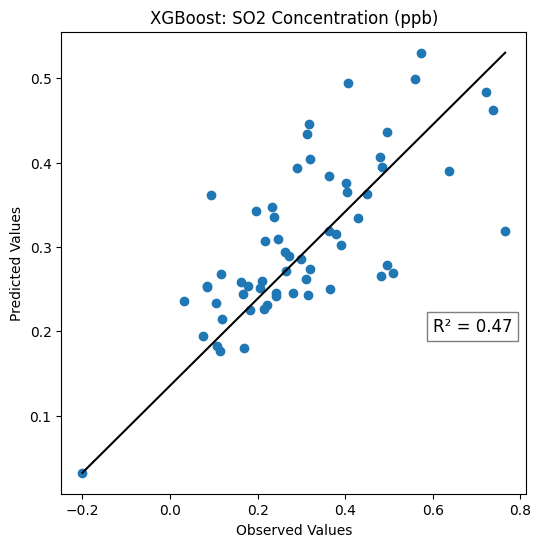

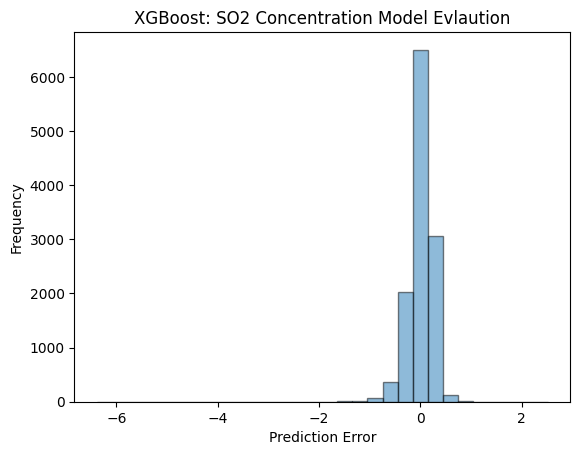

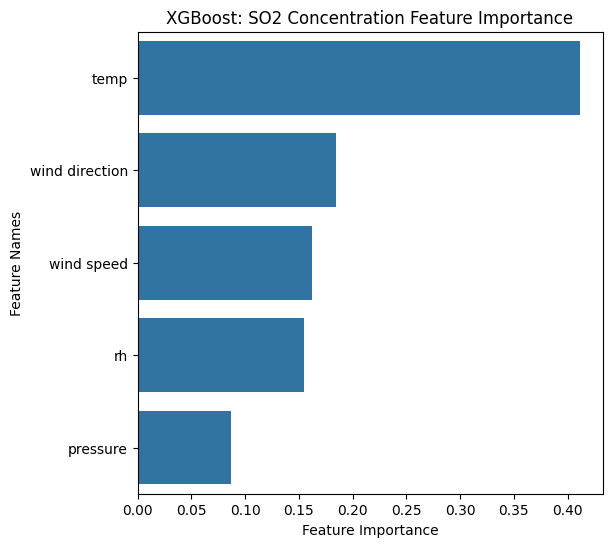

In [15]:
#SO2

# Organize data into monthly averages and plot
y_test_predso2 = pd.Series(y_test_predso2)
y_test_predso2 = y_test_predso2.reset_index(drop=True)
time_test_so2 = time_test_so2.reset_index(drop=True)
so2_df  = pd.concat([y_test_predso2, time_test_so2], axis=1)
so2_df.columns = ['SO2', 'Date']
so2_df['Date'] = pd.to_datetime(so2_df['Date'])

# Extract year and month into new columns
so2_df['Year'] = so2_df['Date'].dt.year
so2_df['Month'] = so2_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
so2_average_values = so2_df.groupby(['Year', 'Month'])['SO2'].mean()
so2_average_values_df1 = so2_average_values.reset_index()

#Repeat all above for observed data
y_test_so2 = pd.Series(y_test_so2)
y_test_so2 = y_test_so2.reset_index(drop=True)
time_test_so2 = time_test_so2.reset_index(drop=True)
so2_test_df = pd.concat([y_test_so2, time_test_so2], axis=1)
so2_test_df.columns = ['SO2', 'Date']
so2_test_df['Date'] = pd.to_datetime(so2_test_df['Date'])

# Extract year and month into new columns
so2_test_df['Year'] = so2_test_df['Date'].dt.year
so2_test_df['Month'] = so2_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
so2_average_values1 = so2_test_df.groupby(['Year', 'Month'])['SO2'].mean()
so2_average_values_df2 = so2_average_values1.reset_index()

#Change the series values to dataframes.
so2_average_values_df1['Date'] = pd.to_datetime(so2_average_values_df1['Year'].astype(str) + '-' + so2_average_values_df1['Month'].astype(str))
so2_average_values_df2['Date'] = pd.to_datetime(so2_average_values_df2['Year'].astype(str) + '-' + so2_average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(so2_average_values_df1['Date'], so2_average_values_df1['SO2'], marker='o', label="Predicted Values")  # Create a line plot
plt.plot(so2_average_values_df2['Date'], so2_average_values_df2['SO2'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average SO2 Values From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average SO2 (ppb)')
plt.legend()
plt.show()

# evaluate the predictions
mse_so2_test = mean_squared_error(y_test_so2, y_test_predso2)
print("Test Mean Squared Error:", mse_so2_test)
mse_so2_train = mean_squared_error(y_train_so2, y_train_predso2)
print("Train Mean Squared Error:", mse_so2_train)

mae_so2_test = mean_absolute_error(y_test_so2, y_test_predso2)
print(f"Test Mean Absolute Error: {mae_so2_test}")
mae_so2_train = mean_absolute_error(y_train_so2, y_train_predso2)
print(f"Train Mean Absolute Error: {mae_so2_train}")

rmse_so2_test = mean_squared_error(y_test_so2, y_test_predso2, squared=False)
print(f"Test Root Mean Squared Error: {rmse_so2_test}")
rmse_so2_train = mean_squared_error(y_train_so2, y_train_predso2, squared=False)
print(f"Train Root Mean Squared Error: {rmse_so2_train}")

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(so2_average_values_df2['SO2'], so2_average_values_df1['SO2'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(so2_average_values_df2['SO2'], so2_average_values_df1['SO2'])
plt.plot([so2_average_values_df2['SO2'].min(), so2_average_values_df2['SO2'].max()], [so2_average_values_df1['SO2'].min(), so2_average_values_df1['SO2'].max()], 'k-')  
plt.title(f'XGBoost: SO2 Concentration (ppb)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(0.6, 0.2 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

#Prediction Error Histogram
prediction_error(y_test_predso2, y_test_so2, 'XGBoost','SO2')

#Feature Importance
plot_feature_importance(xgb_regressor3.feature_importances_, X_train_fi_so2.columns, 'XGBoost','SO2')

## O3 Model Building

In [16]:
#O3
# The following code has been taken from Professor Pierre Gentine's notes for EAEE 4000 Machine Learning for Environmental Engineering
# XGBoost Lecture

# hyperparameters option list
n_estimators_list = [int(x) for x in np.linspace(start=20, stop=100, num=9)]
max_depth_list = [5, 10, 15, 20]
reg_alpha_list = [0.2, 0.3, 0.4, 0.5]
reg_lambda_list = [0.5, 0.6, 0.7, 0.8, 0.9]
subsample_list = [0.5, 0.6, 0.7, 0.8, 0.9]
eta_list = [0.05, 0.1, 0.0001, 0.2]
eval_metric_list = ['rmse','mae','mape','logloss']

# Initialize domain space for range of values 
space={'n_estimators': hp.choice('n_estimators', n_estimators_list),
       'max_depth': hp.choice("max_depth", max_depth_list),
       'gamma': hp.uniform ('gamma', 0, 0.001),
       'reg_alpha' : hp.choice('reg_alpha', reg_alpha_list),
       'reg_lambda' : hp.choice('reg_lambda', reg_lambda_list),
       'subsample' : hp.choice('subsample', subsample_list),
       'eta' : hp.choice('eta', eta_list),
       'eval_metric' : hp.choice('eval_metric', eval_metric_list),
       'tree_method' : 'hist',
       'seed': 5
    }

# define objective function
def objective(space):
    n_estimators = space['n_estimators']
    learning_rate = space['eta']
    gamma = space['gamma']
    max_depth = int(space['max_depth'])
    subsample = space['subsample']
    lamb = space['reg_lambda']
    alpha = space['reg_alpha']
    eval_metric = space['eval_metric']
    seed = space['seed']
    
    xgb_regressor = XGBRegressor(n_estimators = n_estimators,
                                 eta = learning_rate,
                                 gamma = gamma,
                                 max_depth = max_depth,
                                 subsample = subsample,
                                 reg_lambda = lamb,
                                 reg_alpha = alpha,
                                 tree_method = 'hist',
                                 eval_metric = eval_metric,
                                 seed = 5,
                                 verbosity = 1)

    
    xgb_regressor.fit(X_train_o3, y_train_o3)
    
    y_test_pred4 = xgb_regressor.predict(X_test_o3)
    
    rmse = mean_squared_error(y_test_o3, y_test_pred4, squared=False)
    print("loss (rmse): "+str(rmse))
    print("n_estimators = "+str(n_estimators)+"; eta = "+str(learning_rate)+"; gamma = "+str(gamma)+"; max_depth = "+str(max_depth))
    print("subsample = "+str(subsample)+"; reg_lambda = "+str(lamb)+"; reg_alpha = "+str(alpha)+"; eval_metric = "+str(eval_metric))
    print('----------------------------------------------------------------------------------------')
    return {'loss': rmse, 'status': STATUS_OK }

# find the best hyperparameters of 100 trials
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams) # if hp.choice, the output is the position of the list
print("eta = ", eta_list[best_hyperparams['eta']]) # an example of find the exact value of the position


# build a regressor with the best hyperparameters
xgb_regressor4 = XGBRegressor(n_estimators = n_estimators_list[best_hyperparams['n_estimators']],
                              eta = eta_list[best_hyperparams['eta']],
                              gamma = best_hyperparams['gamma'],
                              max_depth = max_depth_list[best_hyperparams['max_depth']],
                              subsample = subsample_list[best_hyperparams['subsample']],
                              reg_lambda = reg_lambda_list[best_hyperparams['reg_lambda']],
                              reg_alpha = reg_alpha_list[best_hyperparams['reg_alpha']],
                              tree_method = 'hist',
                              eval_metric = eval_metric_list[best_hyperparams['eval_metric']],
                              seed = 5,
                              verbosity = 1)

xgb_regressor4.fit(X_train_o3, y_train_o3)

y_test_predo3 = xgb_regressor4.predict(X_test_o3)
y_train_predo3 = xgb_regressor4.predict(X_train_o3)

loss (rmse): 0.00984549135481644                                                                                                         
n_estimators = 90; eta = 0.2; gamma = 0.0006306948181557291; max_depth = 15                                                              
subsample = 0.8; reg_lambda = 0.9; reg_alpha = 0.2; eval_metric = logloss                                                                
----------------------------------------------------------------------------------------                                                 
loss (rmse): 0.0099950655637359                                                                                                          
n_estimators = 50; eta = 0.1; gamma = 0.0003957927831663889; max_depth = 10                                                              
subsample = 0.6; reg_lambda = 0.9; reg_alpha = 0.5; eval_metric = rmse                                                                   
----------------------------------

In [17]:
# Best model based on hyperparameter tuning
# set up xgboost regressor
n_estimators  = 83     # specifies the number of decision trees to be boosted
learning_rate = 0.1    # learning_rate, range: [0,1]
gamma         = 0.00042196110556758207      # Minimum loss reduction required to make a further partition on a leaf node of the tree,
                       # range: [0,∞]
max_depth     = 10     # Maximum depth of a tree, range: [0,∞]
subsample     = 0.8    # Subsample ratio of the training instances, range: (0,1]
lamb          = 0.7    # L2 regularization, range: [0,∞]
alpha         = 0.3    # L1 regularization, range: [0,∞]
tree_method   = 'hist' # The tree construction algorithm used in XGBoost
eval_metric   = 'rmse' # Evaluation metrics for validation data; 
                       # Options: rmse, rmsle, mae, mape, logloss, etc
seed          = 5      # random number seed

xgb_regressor4 = XGBRegressor(n_estimators = n_estimators,
                              eta = learning_rate,
                              gamma = gamma,
                              max_depth = max_depth,
                              subsample = subsample,
                              reg_lambda = lamb,
                              reg_alpha = alpha,
                              tree_method = tree_method,
                              eval_metric = eval_metric,
                              seed = seed,
                              verbosity = 1)

xgb_regressor4.fit(X_train_o3, y_train_o3)

y_test_predo3 = xgb_regressor4.predict(X_test_o3)
y_train_predo3 = xgb_regressor4.predict(X_train_o3)

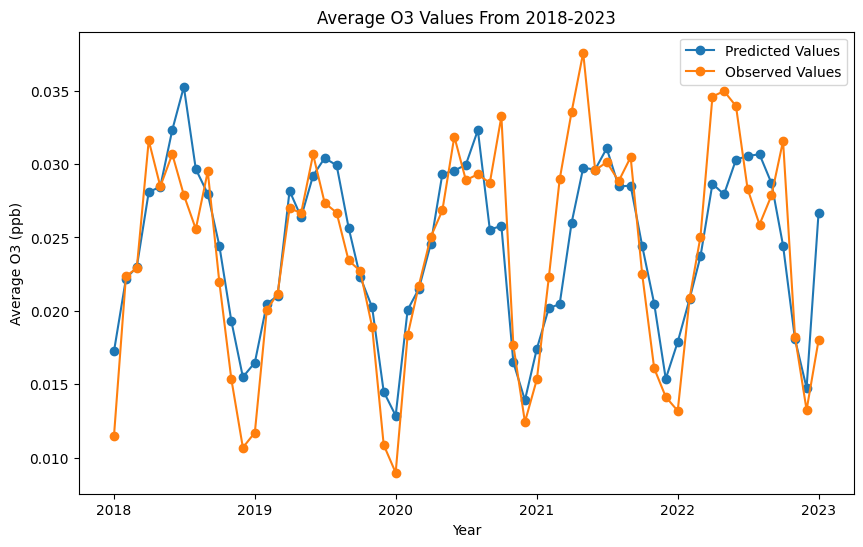

Test Mean Squared Error: 9.680247175794739e-05
Train Mean Squared Error: 9.06887937204902e-05
Test Mean Absolute Error: 0.0075545764570452804
Train Mean Absolute Error: 0.007354107100993789
Test Root Mean Squared Error: 0.41658772613294204
Train Root Mean Squared Error: 0.4344594188096285
0.727686040099657


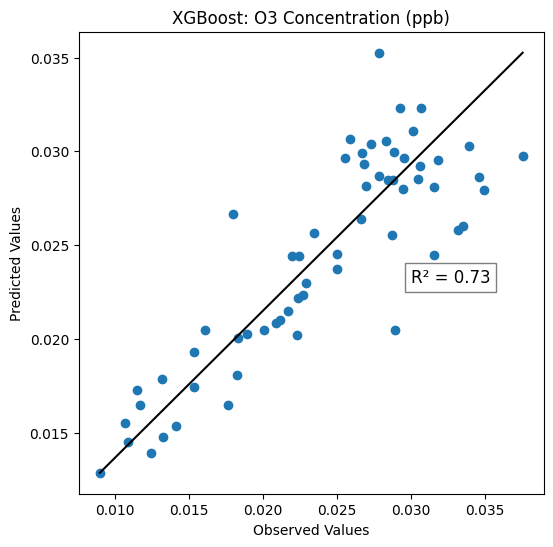

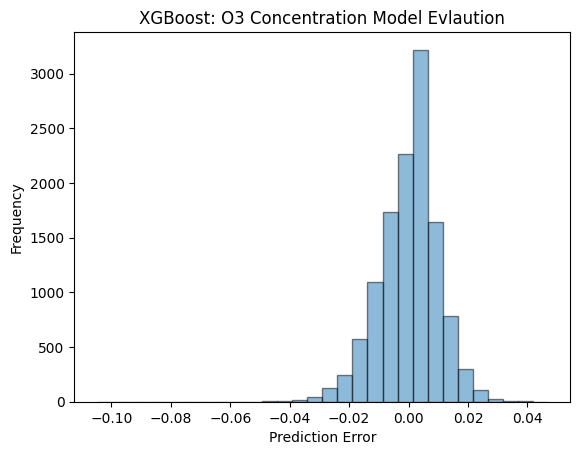

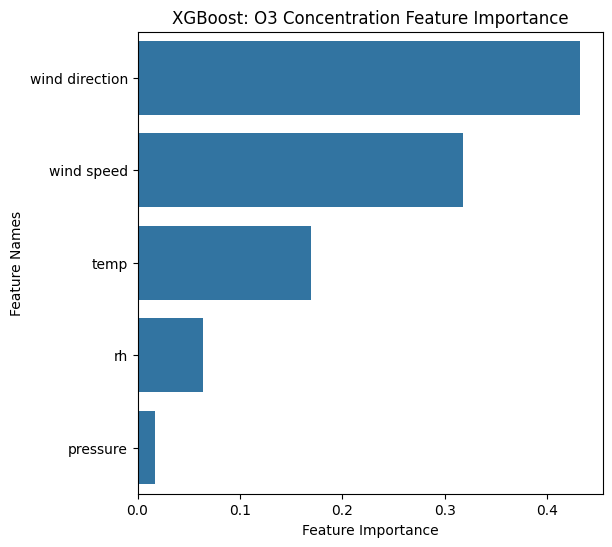

In [18]:
#O3

# Organize data into monthly averages and plot
y_test_predo3  = pd.Series(y_test_predo3 )
y_test_predo3  = y_test_predo3.reset_index(drop=True)
time_test_o3 = time_test_o3.reset_index(drop=True)
o3_df  = pd.concat([y_test_predo3, time_test_o3], axis=1)
o3_df.columns = ['O3', 'Date']
o3_df['Date'] = pd.to_datetime(o3_df['Date'])

# Extract year and month into new columns
o3_df['Year'] = o3_df['Date'].dt.year
o3_df['Month'] = o3_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
o3_average_values = o3_df.groupby(['Year', 'Month'])['O3'].mean()
o3_average_values_df1 = o3_average_values.reset_index()

#Repeat all above for observed data
y_test_o3 = pd.Series(y_test_o3)
y_test_o3 = y_test_o3.reset_index(drop=True)
time_test_o3 = time_test_o3.reset_index(drop=True)
o3_test_df = pd.concat([y_test_o3, time_test_o3], axis=1)
o3_test_df.columns = ['O3', 'Date']
o3_test_df['Date'] = pd.to_datetime(o3_test_df['Date'])

# Extract year and month into new columns
o3_test_df['Year'] = o3_test_df['Date'].dt.year
o3_test_df['Month'] = o3_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
o3_average_values1 = o3_test_df.groupby(['Year', 'Month'])['O3'].mean()
o3_average_values_df2 = o3_average_values1.reset_index()

#Change the series values to dataframes.
o3_average_values_df1['Date'] = pd.to_datetime(o3_average_values_df1['Year'].astype(str) + '-' + o3_average_values_df1['Month'].astype(str))
o3_average_values_df2['Date'] = pd.to_datetime(o3_average_values_df2['Year'].astype(str) + '-' + o3_average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(o3_average_values_df1['Date'], o3_average_values_df1['O3'], marker='o', label="Predicted Values")  # Create a line plot
plt.plot(o3_average_values_df2['Date'], o3_average_values_df2['O3'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average O3 Values From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average O3 (ppb)')
plt.legend()
plt.show()

# evaluate the predictions
mse_test_o3 = mean_squared_error(y_test_o3, y_test_predo3)
print("Test Mean Squared Error:", mse_test_o3)
mse_train_o3 = mean_squared_error(y_train_o3, y_train_predo3)
print("Train Mean Squared Error:", mse_train_o3)

mae_test_o3 = mean_absolute_error(y_test_o3,y_test_predo3)
print(f"Test Mean Absolute Error: {mae_test_o3}")
mae_train_o3 = mean_absolute_error(y_train_o3,y_train_predo3)
print(f"Train Mean Absolute Error: {mae_train_o3}")

rmse_test_o3 = mean_squared_error(y_test_so2, y_test_predo3 , squared=False)
print(f"Test Root Mean Squared Error: {rmse_test_o3}")
rmse_train_o3 = mean_squared_error(y_train_so2, y_train_predo3 , squared=False)
print(f"Train Root Mean Squared Error: {rmse_train_o3}")

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(o3_average_values_df2['O3'], o3_average_values_df1['O3'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(o3_average_values_df2['O3'], o3_average_values_df1['O3'])
plt.plot([o3_average_values_df2['O3'].min(), o3_average_values_df2['O3'].max()], [o3_average_values_df1['O3'].min(), o3_average_values_df1['O3'].max()], 'k-')  
plt.title(f'XGBoost: O3 Concentration (ppb)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(0.030, 0.023 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()


#Prediction Error Histogram
prediction_error(y_test_predo3, y_test_o3, 'XGBoost','O3')

#Feature Importance
plot_feature_importance(xgb_regressor4.feature_importances_, X_train_fi_o3.columns,'XGBoost', 'O3')


## Meteorological Normalization

In [21]:
df_orig = pd.read_excel("Data/metdata_2018-2023_ELABHWC.xlsx")
sum_of_predictions_co, sum_of_predictions_no2 = np.zeros([43789]), np.zeros([43789])
sum_of_predictions_so2, sum_of_predictions_o3 = np.zeros([43789]), np.zeros([43789])
number_of_iterations = 25

for i in range(number_of_iterations):
    df_rand = pd.read_excel(f"Data/random_weather_datasets/output_{i+1}.xlsx")
    
    df_rand['date_gmt'] = df_orig['date_gmt']
    df_rand['time_gmt'] = df_orig['time_gmt']
    
    df_rand.loc[:, 'wind speed'].fillna(df_new['wind speed'].mean(), inplace=True)
    df_rand.loc[:, 'wind direction'].fillna(df_new['wind direction'].mean(), inplace=True)
    df_rand.loc[:, 'temp'].fillna(df_new['temp'].mean(), inplace=True)
    df_rand.loc[:, 'rh'].fillna(df_new['rh'].mean(), inplace=True)
    df_rand.loc[:, 'pressure'].fillna(df_new['pressure'].mean(), inplace=True)

    X = df_rand[['wind speed', 'wind direction', 'temp', 'rh', 'pressure','date_gmt']]
    
    X = X[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
    #time_co = X_co['date_gmt']
    
    mean, std = X.mean(), X.std()
    
    X = (X - mean)/std
    
    X = X.to_numpy()
    
    Y_co = xgb_regressor1.predict(X)
    sum_of_predictions_co += Y_co

    Y_no2 = xgb_regressor2.predict(X)
    sum_of_predictions_no2 += Y_no2
    
    Y_so2 = xgb_regressor3.predict(X)
    sum_of_predictions_so2 += Y_so2
    
    Y_o3 = xgb_regressor4.predict(X)
    sum_of_predictions_o3 += Y_o3


average_predictions_co = sum_of_predictions_co / number_of_iterations
average_predictions_no2 = sum_of_predictions_no2 / number_of_iterations
average_predictions_so2 = sum_of_predictions_so2 / number_of_iterations
average_predictions_o3 = sum_of_predictions_o3 / number_of_iterations

timeforplot = df_orig['date_gmt']

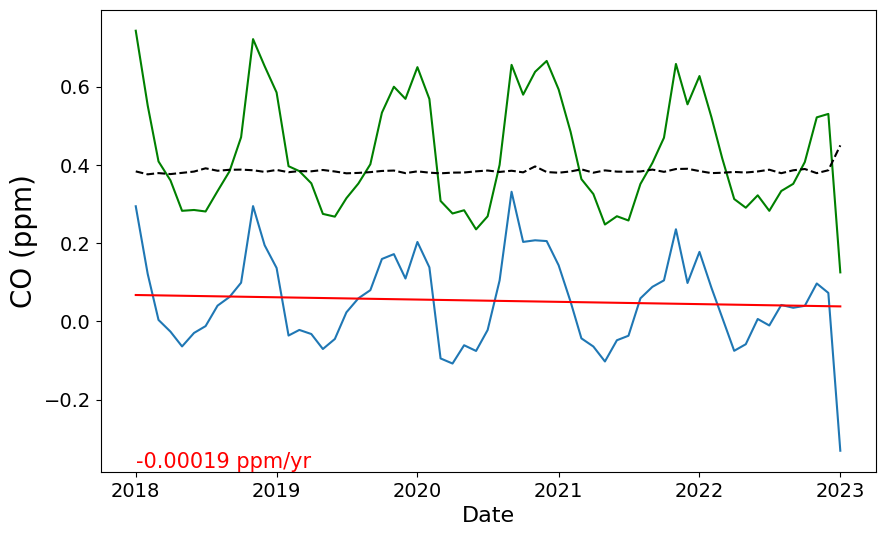

In [23]:
# CO PLOT OF WEATHER NORMALIZATION

weather_norm_co = pd.Series(co_original - average_predictions_co)
y_co = pd.Series(co_original)
weather_prediction_co = pd.Series(average_predictions_co)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
co_df = pd.concat([weather_norm_co, timeforplot], axis=1)
co_df.columns = ['CO', 'Date']
co_df['Date'] = pd.to_datetime(co_df['Date'])

#Group by year and month, then calculate the mean of the 'CO' column
co_df['Year'] = co_df['Date'].dt.year
co_df['Month'] = co_df['Date'].dt.month
average_values_1 = co_df.groupby(['Year', 'Month'])['CO'].mean()

average_values_df1 = average_values.reset_index()

co_actual_df = pd.concat([y_co, timeforplot], axis=1)
co_actual_df.columns = ['CO', 'Date']
co_actual_df['Date'] = pd.to_datetime(co_df['Date'])

#Do the same thing for the observed values
co_df['Year'] = co_df['Date'].dt.year
co_df['Month'] = co_df['Date'].dt.month
average_values = co_df.groupby(['Year', 'Month'])['CO'].mean()
co_actual_df['Year'] = co_actual_df['Date'].dt.year
co_actual_df['Month'] = co_actual_df['Date'].dt.month
average_values_2 = co_actual_df.groupby(['Year', 'Month'])['CO'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_co, timeforplot], axis=1)
weather_df.columns = ['CO', 'Date']
weather_df['Date'] = pd.to_datetime(no2_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['CO'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['CO'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['CO'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['CO'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['CO']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Date', fontsize=16)  # Increase x-axis label font size
plt.ylabel('CO (ppm)', fontsize=20)  # Increase y-axis label font size
plt.text(x_position, y_position, f'{formatted_slope} ppm/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()

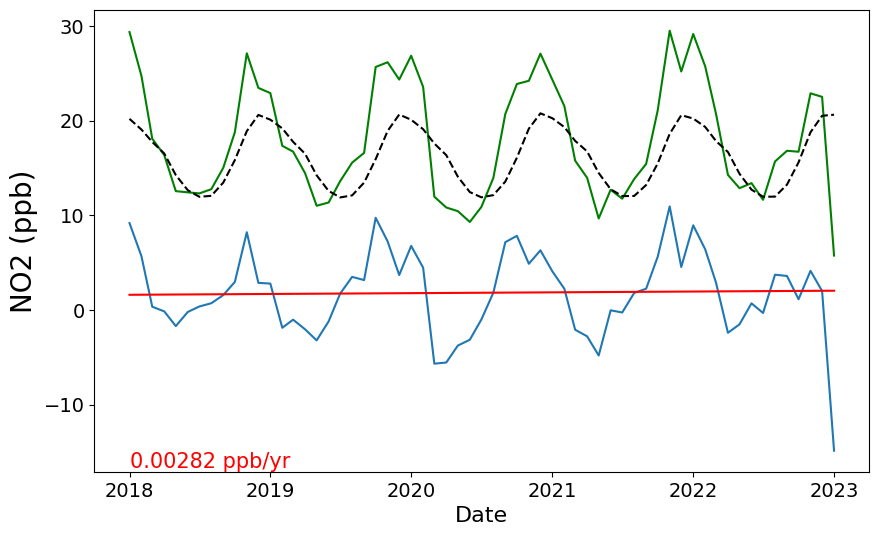

In [24]:
#NO2 PLOT OF WEATHER NORMALIZATION

weather_norm_no2 = pd.Series(no2_original - average_predictions_no2)
y_no2 = pd.Series(no2_original)
weather_prediction_no2 = pd.Series(average_predictions_no2)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
no2_df = pd.concat([weather_norm_no2, timeforplot], axis=1)
no2_df.columns = ['NO2', 'Date']
no2_df['Date'] = pd.to_datetime(no2_df['Date'])

no2_df['Year'] = no2_df['Date'].dt.year
no2_df['Month'] = no2_df['Date'].dt.month
average_values_1 = no2_df.groupby(['Year', 'Month'])['NO2'].mean()

average_values_df1 = average_values.reset_index()

no2_actual_df = pd.concat([y_no2, timeforplot], axis=1)
no2_actual_df.columns = ['NO2', 'Date']
no2_actual_df['Date'] = pd.to_datetime(no2_df['Date'])

#Do the same thing for the observed values
no2_df['Year'] = no2_df['Date'].dt.year
no2_df['Month'] = no2_df['Date'].dt.month
average_values = no2_df.groupby(['Year', 'Month'])['NO2'].mean()
no2_actual_df['Year'] = no2_actual_df['Date'].dt.year
no2_actual_df['Month'] = no2_actual_df['Date'].dt.month
average_values_2 = no2_actual_df.groupby(['Year', 'Month'])['NO2'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_no2, timeforplot], axis=1)
weather_df.columns = ['NO2', 'Date']
weather_df['Date'] = pd.to_datetime(no2_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['NO2'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['NO2'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['NO2'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['NO2'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['NO2']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Date', fontsize=16)  # Increase x-axis label font size
plt.ylabel('NO2 (ppb)', fontsize=20)  # Increase y-axis label font size

plt.text(x_position, y_position, f'{formatted_slope} ppb/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()

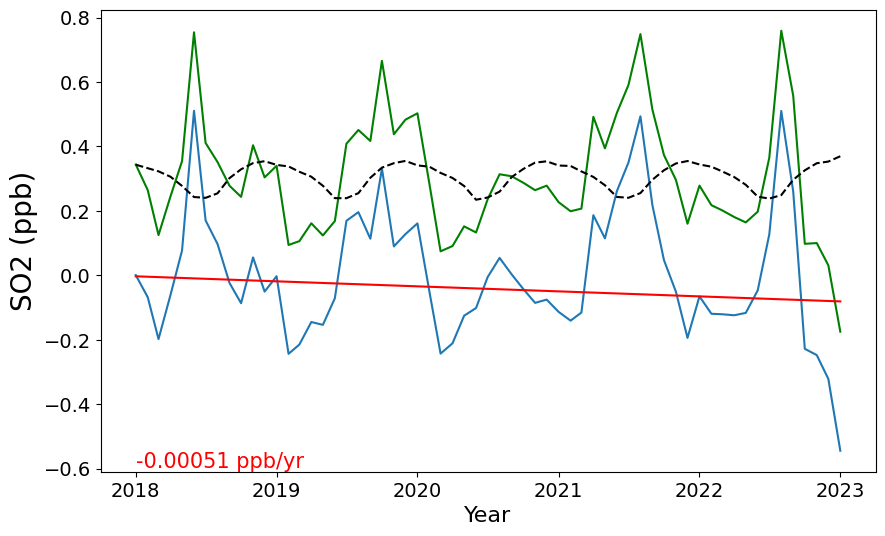

In [26]:
#SO2 PLOT OF WEATHER NORMALIZATION

weather_norm_so2 = pd.Series(so2_original - average_predictions_so2)
y_so2 = pd.Series(so2_original)
weather_prediction_so2 = pd.Series(average_predictions_so2)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
so2_df = pd.concat([weather_norm_so2, timeforplot], axis=1)
so2_df.columns = ['SO2', 'Date']
so2_df['Date'] = pd.to_datetime(so2_df['Date'])

so2_df['Year'] = so2_df['Date'].dt.year
so2_df['Month'] = so2_df['Date'].dt.month
average_values_1 = so2_df.groupby(['Year', 'Month'])['SO2'].mean()

average_values_df1 = average_values.reset_index()

so2_actual_df = pd.concat([y_so2, timeforplot], axis=1)
so2_actual_df.columns = ['SO2', 'Date']
so2_actual_df['Date'] = pd.to_datetime(so2_df['Date'])

#Do the same thing for the observed values
so2_df['Year'] = so2_df['Date'].dt.year
so2_df['Month'] = so2_df['Date'].dt.month
average_values = so2_df.groupby(['Year', 'Month'])['SO2'].mean()
so2_actual_df['Year'] = so2_actual_df['Date'].dt.year
so2_actual_df['Month'] = so2_actual_df['Date'].dt.month
average_values_2 = so2_actual_df.groupby(['Year', 'Month'])['SO2'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_so2, timeforplot], axis=1)
weather_df.columns = ['SO2', 'Date']
weather_df['Date'] = pd.to_datetime(so2_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['SO2'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['SO2'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['SO2'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['SO2'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['SO2']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Year', fontsize=16)  # Increase x-axis label font size
plt.ylabel('SO2 (ppb)', fontsize=20)  # Increase y-axis label font size

plt.text(x_position, y_position, f'{formatted_slope} ppb/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()

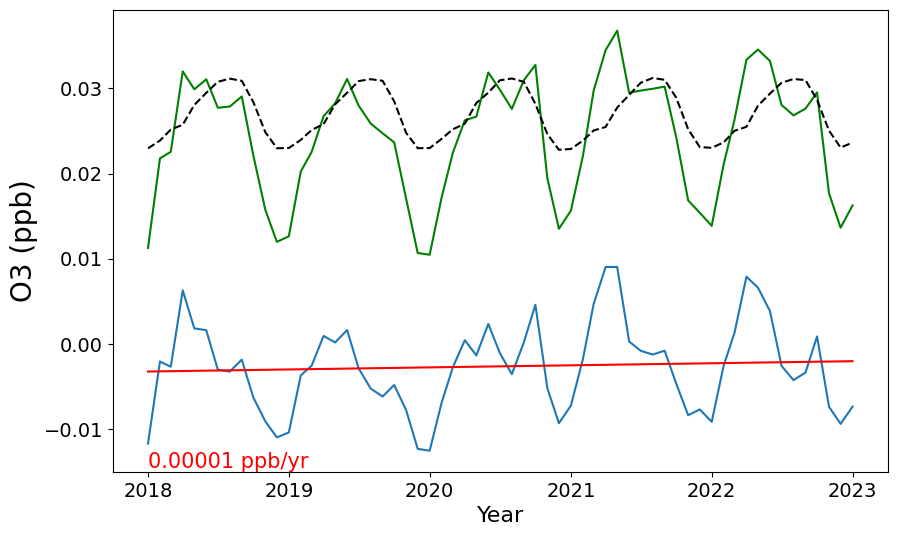

In [27]:
#O3 PLOT OF WEATHER NORMALIZATION

weather_norm_o3 = pd.Series(o3_original - average_predictions_o3)
y_o3 = pd.Series(o3_original)
weather_prediction_o3 = pd.Series(average_predictions_o3)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
o3_df = pd.concat([weather_norm_o3, timeforplot], axis=1)
o3_df.columns = ['O3', 'Date']
o3_df['Date'] = pd.to_datetime(o3_df['Date'])

o3_df['Year'] = o3_df['Date'].dt.year
o3_df['Month'] = o3_df['Date'].dt.month
average_values_1 = o3_df.groupby(['Year', 'Month'])['O3'].mean()

average_values_df1 = average_values.reset_index()

o3_actual_df = pd.concat([y_o3, timeforplot], axis=1)
o3_actual_df.columns = ['O3', 'Date']
o3_actual_df['Date'] = pd.to_datetime(o3_df['Date'])

#Do the same thing for the observed values
o3_df['Year'] = o3_df['Date'].dt.year
o3_df['Month'] = o3_df['Date'].dt.month
average_values = o3_df.groupby(['Year', 'Month'])['O3'].mean()
o3_actual_df['Year'] = o3_actual_df['Date'].dt.year
o3_actual_df['Month'] = o3_actual_df['Date'].dt.month
average_values_2 = o3_actual_df.groupby(['Year', 'Month'])['O3'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_o3, timeforplot], axis=1)
weather_df.columns = ['O3', 'Date']
weather_df['Date'] = pd.to_datetime(o3_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['O3'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['O3'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['O3'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['O3'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['O3']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Year', fontsize=16)  # Increase x-axis label font size
plt.ylabel('O3 (ppb)', fontsize=20)  # Increase y-axis label font size

plt.text(x_position, y_position, f'{formatted_slope} ppb/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()